In [29]:
import os
import re

In [30]:
DATA_DIR = os.path.join(os.path.abspath("."), "data")
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

In [31]:
train_features = [f for f in os.listdir(TRAIN_DIR) if f.endswith(".png") and not f.endswith("_GT.png")]
train_masks = [f for f in os.listdir(TRAIN_DIR) if f.endswith("_GT.png")]

print("Number of train features:", len(train_features))
print("Number of train masks:", len(train_masks))

Number of train features: 0
Number of train masks: 0


In [32]:
# dataset contains one copied sample with (copy) in name -> identify and remove
[i for i in train_features if i.split(".")[0] + "_GT.png" not in train_masks]

[]

## Organizing Directories
current structure:  `data/train` & `data/test`

split both train and test based on whether they are defective or not

i.e `data/*/defect` & `data/*/no_defect`

In [33]:
from PIL import Image
import numpy as np

In [34]:
def split_defective(dirname):
    images = [f.split(".")[0] for f in os.listdir(dirname) if f.endswith(".png") and not f.endswith("_GT.png")]
    for img in images:
        mask = np.array(Image.open(os.path.join(dirname, img + "_GT.png")))
        if mask.sum() > 0:
            os.rename(os.path.join(dirname, img + ".png"),os.path.join(dirname, "defect", img + ".png"))
            os.rename(os.path.join(dirname, img + "_GT.png"),os.path.join(dirname, "defect", img + "_GT.png"))
        else:
            os.rename(os.path.join(dirname, img + ".png"),os.path.join(dirname, "no_defect", img + ".png"))
            os.rename(os.path.join(dirname, img + "_GT.png"),os.path.join(dirname, "no_defect", img + "_GT.png"))

In [35]:
split_defective(TRAIN_DIR)

In [36]:
num_train_defect = len([f for f in os.listdir(TRAIN_DIR + "\\defect") if not f.endswith("_GT.png")])
num_train_no_defect = len([f for f in os.listdir(TRAIN_DIR + "\\no_defect") if not f.endswith("_GT.png")])

num_test_defect = len([f for f in os.listdir(TEST_DIR + "\\defect") if not f.endswith("_GT.png")])
num_test_no_defect = len([f for f in os.listdir(TEST_DIR + "\\no_defect") if not f.endswith("_GT.png")])

print("Number of defective images in TRAIN:", num_train_defect)
print("Number of non-defective images in TRAIN:", num_test_no_defect)
print("Number of defective images in TEST:", num_test_defect)
print("Number of non-defective images in TEST:", num_test_no_defect)

Number of defective images in TRAIN: 246
Number of non-defective images in TRAIN: 894
Number of defective images in TEST: 110
Number of non-defective images in TEST: 894


In [37]:
split_defective(TEST_DIR)

## Configuring Data Loading

In [52]:
import torch as t
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.utils.data.sampler import BatchSampler
import random
import matplotlib.pyplot as plt

In [39]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(device)

cuda


In [54]:
class TripletDataset(Dataset):
    def __init__(self, root_dir, model=None, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # model to compute the embeddings with
        self.model = model
        self.image_paths = []
        self.labels = []
        
        for label in os.listdir(root_dir):
            label_dir = os.path.join(root_dir, label)
            label_val = 1 if label == "defect" else 0
            if os.path.isdir(label_dir):
                img_list = [os.path.join(label_dir, img) for img in os.listdir(label_dir) if not img.endswith("_GT.png")]
                self.image_paths.extend(img_list)
                self.labels.extend([label_val] * len(img_list)) 

        self.labels_to_indices = {}
        for i, label in enumerate(self.labels):
            if label not in self.labels_to_indices:
                self.labels_to_indices[label] = []
            self.labels_to_indices[label].append(i)
        
        self.labels_set = list(set(self.labels))
            
                
    
    def __getitem__(self, index):
        img = Image.open(self.image_paths[index]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.labels[index], index
    
    def __len__(self):
        return len(self.image_paths)
                

In [ ]:
def get_semi_hard_triplets(embeddings, labels, margin=0.2):
    # get distances for each embedding to every other embedding 
    distance_matrix = t.cdist(embeddings, embeddings, p=2)
    triplets = []
    
    for i in range(len(embeddings)):
        
        anchor_label = labels[i]
        
        # indicies of all samples with the same label as anchor (excluding the achor)
        pos_indices = t.where(labels == anchor_label)[0].to(device)
        pos_indices = pos_indices[pos_indices != i]
        
        if len(pos_indices) == 0:
            continue
        
        # indicies of all samples with a different label as anchor
        neg_indices = t.where(labels != anchor_label)[0].to(device)
        if len(neg_indices) == 0:
            continue
        
        # distances to all the positive samples
        pos_distances = distance_matrix[i, pos_indices]
        closest_pos_idx = pos_indices[t.argmin(pos_distances)] # index of closest positive
        pos_distance = t.min(pos_distances) # distance of closest positive
        
        # distances to all negative samples
        neg_distances = distance_matrix[i, neg_indices]
        # semi-hard triplet constraint
        # negative distance is greater than postive but negative is still within the margin
        semi_hard_mask = (neg_distances > pos_distance) & (neg_distances < pos_distance + margin) 

        if t.sum(semi_hard_mask) > 0:
            semi_hard_indices = neg_indices[semi_hard_mask]
            neg_idx = semi_hard_indices[t.randint(0, len(semi_hard_indices), (1,))] # random negative from the masked set
        else:
            neg_idx = neg_indices[t.argmin(neg_distances)] # else closest negative
        triplets.append((i, closest_pos_idx, neg_idx))
    
    return triplets

In [42]:
def create_dataloader(dataset, batch_size):
    class_counts = np.bincount(dataset.labels)
    weights = 1.0 / class_counts[dataset.labels]

    sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

    dataloader = DataLoader(
        dataset,
        batch_size,
        sampler=sampler,
        pin_memory=True
    )
    return dataloader

In [43]:
# Get Weighted Sampler to assign weights to each sample based on class frequency
def get_sampler(dataset):
    labels = [sample[2] for sample in dataset.samples]
    class_counts = np.bincount(labels)
    class_weights = 10.0 / class_counts
    
    print(class_weights)
    
    sample_weights = [class_weights[label] for label in labels]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    return sampler

In [44]:
BATCH_SIZE=16

img_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
    transforms.RandomRotation(degrees=20),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

train_dataset = TripletDataset(TRAIN_DIR, transform=img_transform)
test_dataset = DefectDataset(TEST_DIR, transform=test_transform)

train_dataloader = create_dataloader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=BATCH_SIZE)

In [45]:
def show_img(tensor):
    img = tensor.permute(1,2,0)
    plt.imshow(img)


## Configuring ResNet

In [46]:
import torchvision.models as models
from torch import nn
import torch.nn.functional as F

In [47]:
resnet = models.resnet50(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False


In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
    
    def forward(self, anchor, positive, negative):
        anchor = anchor.unsqueeze(0)
        positive = positive.unsqueeze(0)
        negative = negative.unsqueeze(0)
        
        pos_dist = t.norm(anchor - positive, p=2)
        neg_dist = t.norm(anchor - negative, p=2)
        loss += t.clamp(pos_dist - neg_dist + self.margin, min=0)
        
        return self.loss_fn(anchor, positive, negative)

In [81]:
class DefectDetector(nn.Module):
    def __init__(self, backbone, embedding_dim=512, freeze_backbone=True):
        super(DefectDetector, self).__init__()
        
        self.backbone = backbone(pretrained=True)
        
        if freeze_backbone:
            for param in list(self.backbone.parameters())[:-10]:
                param.requires_grad = False
        
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        self.embeddings = nn.Sequential(
            nn.Linear(in_features, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048),
            nn.Linear(2048, 512)
        )

    def batch_forward(self, x):
        logits = self.backbone(x)
        embeds = F.normalize(self.embeddings(logits), p=2, dim=1)
        return embeds

    def forward(self, anchor, positive, negative):
        anchor_feat = self.backbone(anchor)
        positive_feat = self.backbone(positive)
        negative_feat = self.backbone(negative)

        anchor_embed = F.normalize(self.embeddings(anchor_feat), p=2, dim=1)
        positive_embed = F.normalize(self.embeddings(positive_feat), p=2, dim=1)
        negative_embed = F.normalize(self.embeddings(negative_feat), p=2, dim=1)

        return anchor_embed, positive_embed, negative_embed
        
        

    def fit(self, train_dataset, optimizer, lr=0.001, loss_margin=1.0, batch_size=32, epochs=50):
        
        self.train()
        dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        criterion = TripletLoss(margin=loss_margin)
        optim = optimizer(self.embeddings.parameters(), weight_decay=1e-4, lr=lr)
        
        history = {
            "loss": [],
            "epoch_losses": []
        }
        
        # for each epoch
        for epoch in range(epochs):
            running_loss = 0.0
            # for each minibatch
            optim.zero_grad()
            for images, labels, indices in dataloader:
                images = images.to(device)
                embeddings = self.batch_forward(images)

                triplets = get_semi_hard_triplets(embeddings, labels, loss_margin)
                if not triplets:
                    continue
                    
                loss = 0
                for a, p, n in triplets:
                    anchor = embeddings[a].unsqueeze(0)
                    positive = embeddings[p].unsqueeze(0)
                    negative = embeddings[n].unsqueeze(0)

                    pos_dist = t.norm(anchor - positive, p=2)
                    neg_dist = t.norm(anchor - negative, p=2)
                    loss += t.clamp(pos_dist - neg_dist + loss_margin, min=0)

                loss = loss / len(triplets)
                loss.backward()
                optim.step()
                loss_val = loss.item()
                running_loss += loss_val
                history['loss'].append(loss_val)
            print(f"Epoch [{epoch + 1}/{epochs}]")
            history['epoch_losses'].append(running_loss / len(dataloader))
            print(f"Loss: {running_loss / len(dataloader)}")
        return history



In [82]:
model = DefectDetector(backbone=models.resnet18, freeze_backbone=True).to(device)
model

c:\Users\aaadi\anaconda3\envs\torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\aaadi\anaconda3\envs\torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DefectDetector(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [83]:
optim = t.optim.AdamW
history = model.fit(train_dataset, optim, epochs=20, lr=0.001)

Epoch [1/20]
Loss: 0.4838563309956903


KeyboardInterrupt: 

In [75]:
model.eval()


DefectDetector(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [160]:
sample = next(iter(train_dataloader))

In [161]:
predictions = model.forward(sample[0][:25].to(device)).round()
predictions

tensor([[0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [162]:
(predictions[0] == sample[2][:25].to(device)).int()

tensor([1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0',
       dtype=torch.int32)

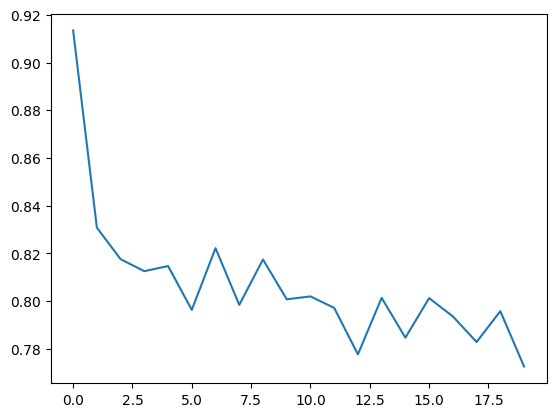

In [80]:
plt.figure()
plt.plot(np.arange(len(history['epoch_losses'])), history['epoch_losses'])
plt.show()

In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
def evaluate(model, test_dataloader, verbose=False):
    all_labels = []
    all_preds = []

    model.eval()
    with t.no_grad():
        for images, masks, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).round()
            preds = outputs.cpu().numpy()
            labels = labels.cpu().numpy()

            all_labels.extend(labels)
            all_preds.extend(preds)

            # Compute metrics for each batch
            acc = accuracy_score(labels, preds)
            if verbose:
                print(f"Batch Accuracy: {acc:.4f}")
                print(classification_report(labels, preds))
                cm = confusion_matrix(labels, preds)
                disp = ConfusionMatrixDisplay(confusion_matrix=cm)
                disp.plot()
                plt.show()

    # Compute metrics for all data combined
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    overall_acc = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {overall_acc:.4f}")
    print(classification_report(all_labels, all_preds))
    overall_cm = confusion_matrix(all_labels, all_preds)
    overall_disp = ConfusionMatrixDisplay(confusion_matrix=overall_cm)
    overall_disp.plot()
    plt.show()

Overall Accuracy: 0.7819
              precision    recall  f1-score   support

           0       0.94      0.81      0.87       894
           1       0.26      0.55      0.35       110

    accuracy                           0.78      1004
   macro avg       0.60      0.68      0.61      1004
weighted avg       0.86      0.78      0.81      1004



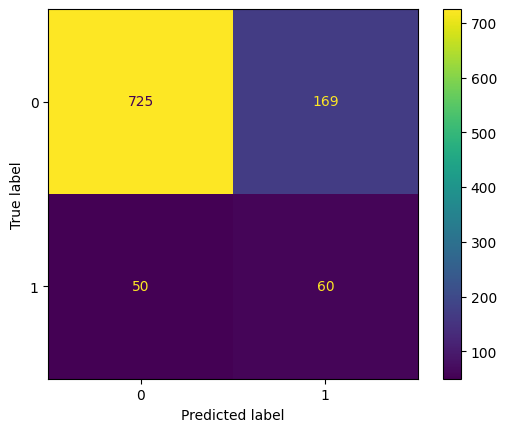

In [39]:
evaluate(model, test_dataloader)